In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, expon
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, roc_curve, auc, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv("telco_TS.csv")

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


**Tiền xử lí dữ liệu**

In [ ]:
def preprocess(df):
    df = df.copy()

    # 1. drop id
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)

    # 2. Chuyển định dạng của TotalCharges
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df['TotalCharges'] = df['TotalCharges'].fillna(0)

    # 3. mapping các biến yes, no (bao gồm cả các cột dịch vụ)
    binary_cols = [
        'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
        'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]

    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].replace({
                'No internet service': 'No',
                'No phone service': 'No'
            })
            df[col] = df[col].map({'Yes': 1, 'No': 0})

    # 4. Xử lí cột có giữ thứ tự
    contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
    if 'Contract' in df.columns:
        df['Contract'] = df['Contract'].map(contract_map)

    # 5. Xử lí cột State và StateNextMonth
    state_cols = ['State', 'StateNextMonth']
    for col in state_cols:
        if col in df.columns:
            df[col] = df[col].map({'Churn': 1, 'No Churn': 0})

    # 6. ONE-HOT ENCODING
    categorical_cols = ['gender', 'InternetService', 'PaymentMethod']
    exist_cat_cols = [col for col in categorical_cols if col in df.columns]
    df = pd.get_dummies(df, columns=exist_cat_cols, drop_first=True)

    # 7. scale miền giá trị về phân phối chuẩn
    cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
    cols_to_scale = [col for col in cols_to_scale if col in df.columns]

    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    # 8. chuyển bool về int (an toàn cho model)
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    return df


df = preprocess(df)


In [ ]:
for col in df.columns:
  print(f'Miền giá trị của cột {col} là: ', df[col].unique())

Miền giá trị của cột SeniorCitizen là:  [0 1]
Miền giá trị của cột Partner là:  [1 0]
Miền giá trị của cột Dependents là:  [0 1]
Miền giá trị của cột tenure là:  [-1.27744458  0.06632742 -1.23672422  0.51425142 -0.99240204 -0.42231695
 -0.91096131 -0.17799476  1.2064976  -0.78880022 -0.66663913  1.04361615
  0.67713287 -0.30015585  1.49154015  0.79929397  1.57298088 -0.46303731
 -0.82952058 -0.09655404  0.59569215  1.61370124 -0.62591876 -0.21871513
 -1.11456313  0.55497178 -0.87024095  1.53226051  1.24721797  0.43281069
 -0.70735949  1.12505688 -0.5851984   1.36937906 -0.95168167 -1.19600386
 -0.05583367  0.71785324  1.28793833  0.96217542 -1.0331224   0.39209033
  0.10704778  0.63641251 -0.1372744   1.32865869  0.22920887  1.45081979
 -0.01511331  0.92145506  0.18848851  0.14776815  0.35136997 -1.07384277
 -1.15528349  0.02560706  1.41009942 -0.38159658  1.00289578  1.16577724
 -0.74807986 -0.50375767  0.84001433  0.3106496   1.08433651 -0.34087622
  0.47353106 -0.54447804  0.8807346

**Vẽ ma trận hệ số tương quan**




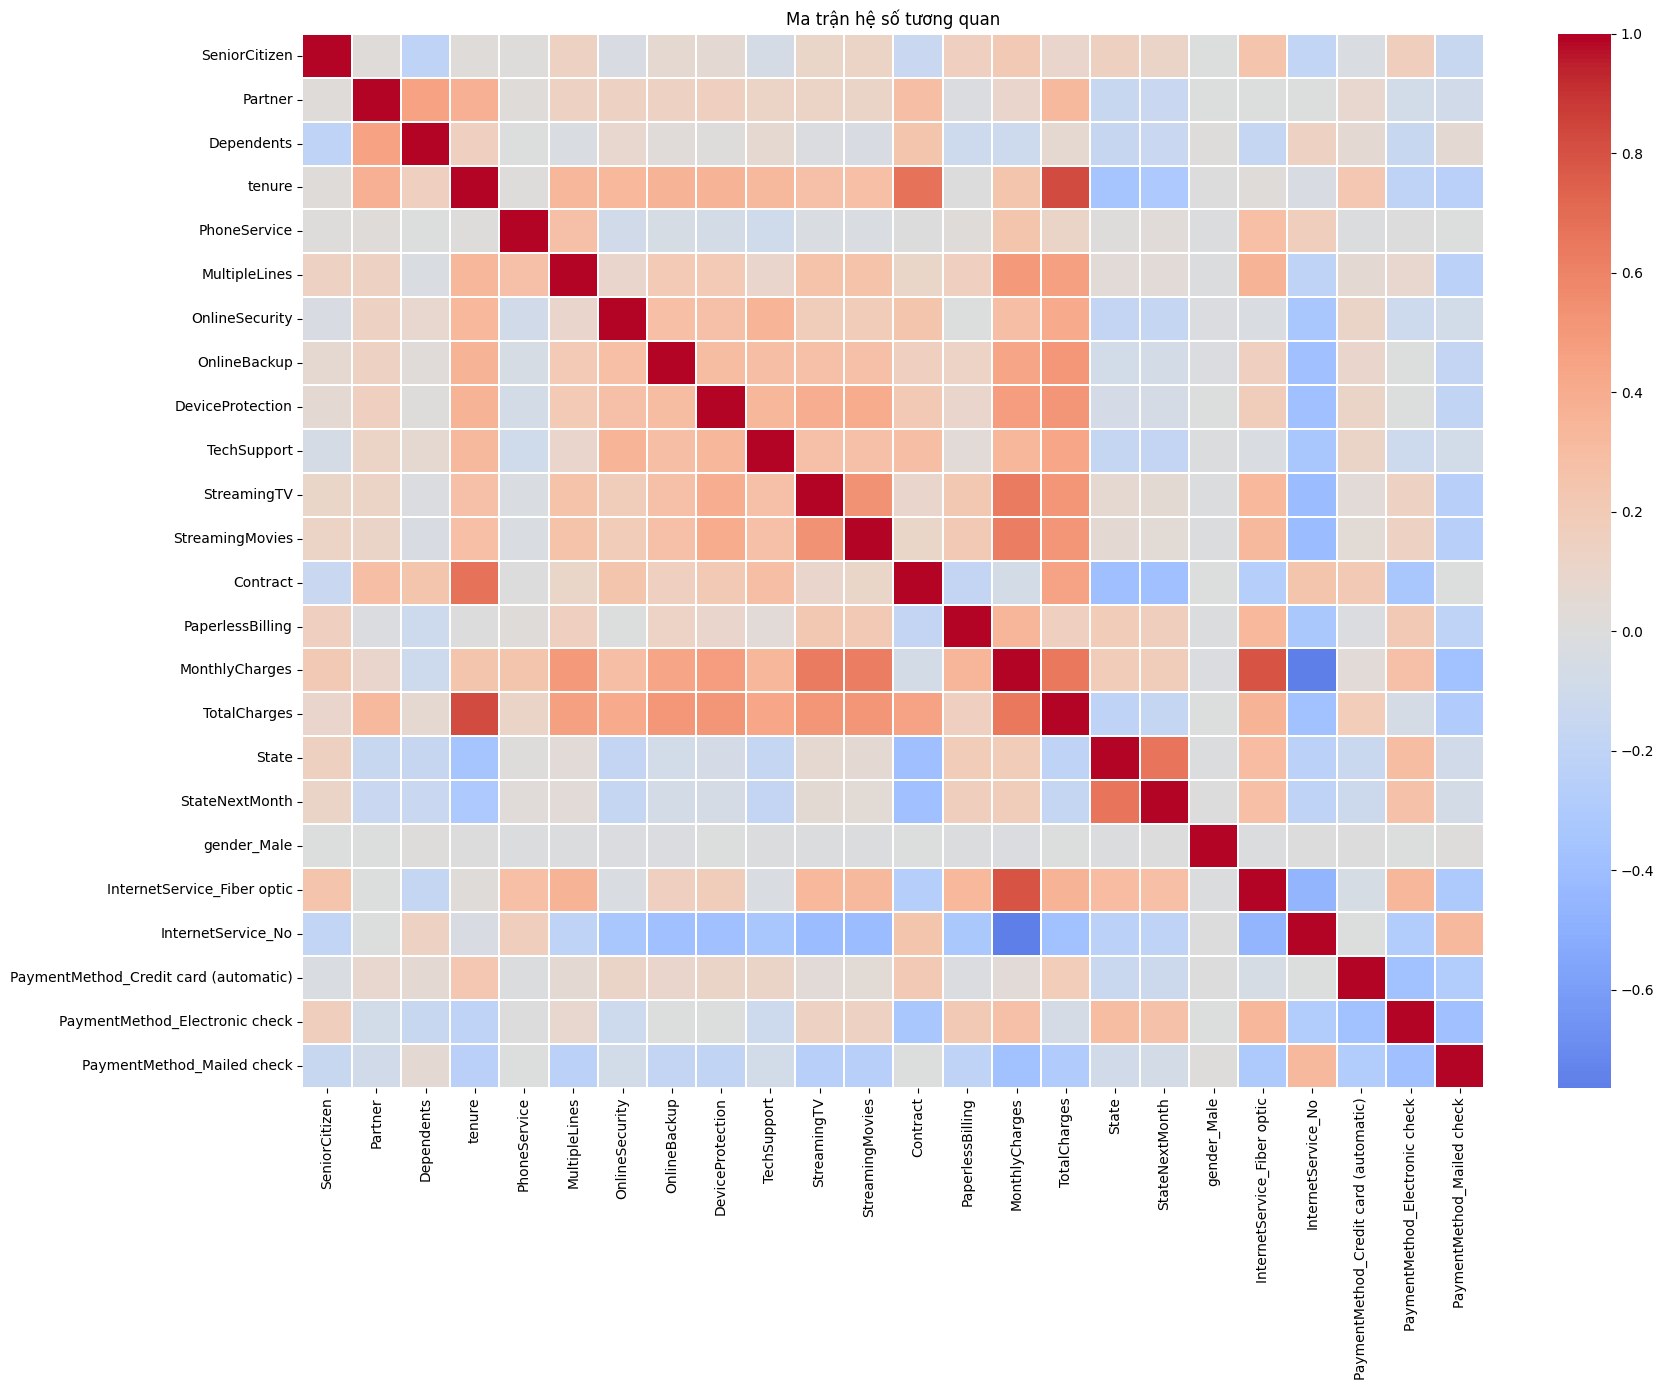

In [ ]:
corr = df.corr()
plt.figure(figsize=(18,14))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    linewidths=0.3
)
plt.title('Ma trận hệ số tương quan')
plt.tight_layout()
plt.savefig('cov_fig.png')
plt.show()


EDA

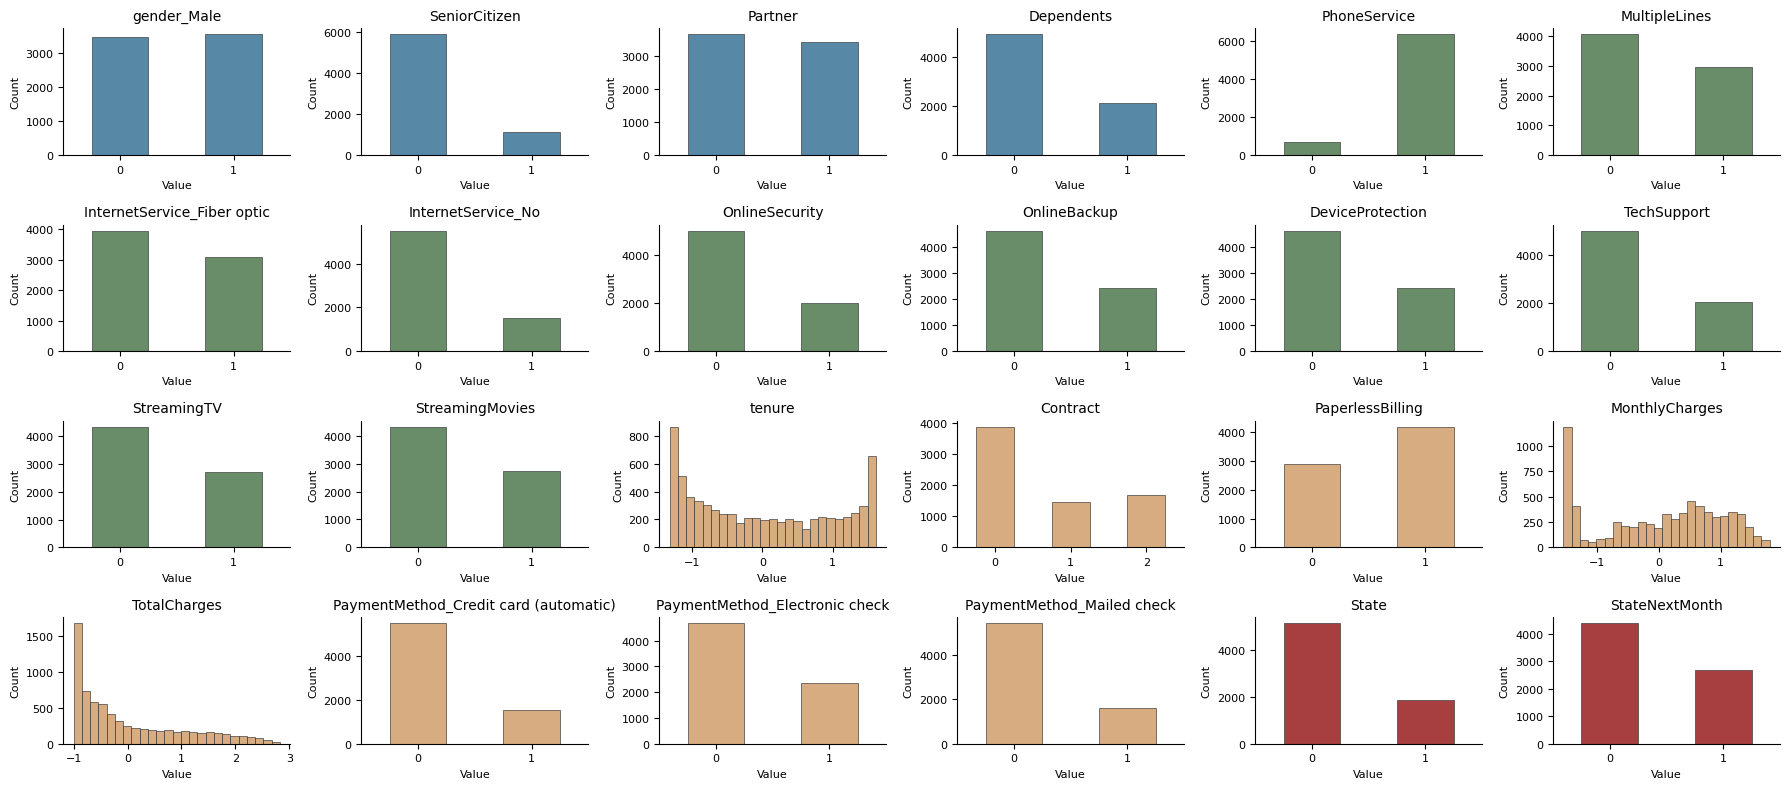

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Định nghĩa nhóm và màu sắc
feature_groups = {
    'Demographics': {
        'cols': ['gender_Male', 'SeniorCitizen', 'Partner', 'Dependents'],
        'color': '#457b9d'  # Xanh biển đậm
    },
    'Services': {
        'cols': ['PhoneService', 'MultipleLines', 'InternetService_Fiber optic',
                 'InternetService_No', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
        'color': '#588157'  # Xanh lá rừng dịu
    },
    'Account & Billing': {
        'cols': ['tenure', 'Contract', 'PaperlessBilling', 'MonthlyCharges',
                 'TotalCharges', 'PaymentMethod_Credit card (automatic)',
                 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
        'color': '#d4a373'  # Màu nâu đất nhạt
    },
    'Status & Location': {
        'cols': ['State', 'StateNextMonth'],
        'color': '#9e2a2b'  # Đỏ đô trầm
    }
}

# 2. Cấu hình Layout
n_cols = 6
total_features = sum(len(g['cols']) for g in feature_groups.values())
n_rows = (total_features // n_cols) + (1 if total_features % n_cols != 0 else 0)

# figsize
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2.0 * n_rows))
axes = axes.flatten()
idx = 0

# 3. Vẽ biểu đồ
for group_name, info in feature_groups.items():
    for col in info['cols']:
        ax = axes[idx]

        if col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
            ax.hist(df[col], bins=25, color=info['color'], alpha=0.9, edgecolor='#333333', linewidth=0.5)
        else:
            counts = df[col].value_counts().sort_index()
            counts.plot(kind='bar', ax=ax, color=info['color'], alpha=0.9, edgecolor='#333333', linewidth=0.5)
            ax.set_xticklabels(counts.index, rotation=0)

        # Định dạng văn phong
        ax.set_title(col, fontsize=10, fontweight='normal', family='sans-serif')
        ax.set_xlabel('Value', fontsize=8, fontweight='normal')
        ax.set_ylabel('Count', fontsize=8, fontweight='normal')
        ax.tick_params(labelsize=8)

        # Tối giản khung hình
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        idx += 1

# Xóa các ô trống
for i in range(idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("eda_ieee_style.png", dpi=300, bbox_inches="tight")
plt.show()

**PCA**

In [ ]:
y = df['StateNextMonth'].values
X1 = df.drop(columns=['StateNextMonth'], errors='ignore') #dùng PCA
X2 = X1.values # không PCA

In [ ]:
mean_vec = np.mean(X1.values, axis=0)
std_vec = np.std(X1.values, axis=0)
std_vec[std_vec == 0] = 1
X_std = (X1.values - mean_vec) / std_vec
n_samples = X_std.shape[0]
cov_matrix = (X_std.T @ X_std) / (n_samples - 1)
eigen_vals, eigen_vecs = np.linalg.eigh(cov_matrix)
idx = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[idx]
eigen_vecs = eigen_vecs[:, idx]
explained_variance_ratio = eigen_vals / np.sum(eigen_vals)
cumulative_variance = np.cumsum(explained_variance_ratio)
k = np.argmax(cumulative_variance >= 0.95) + 1
print(f"giảm từ 23 chiều xuống {k} chiều (giữ {cumulative_variance[k-1]:.2%} phương sai)")
W = eigen_vecs[:, :k]
X1 = X_std @ W


giảm từ 23 chiều xuống 18 chiều (giữ 96.21% phương sai)


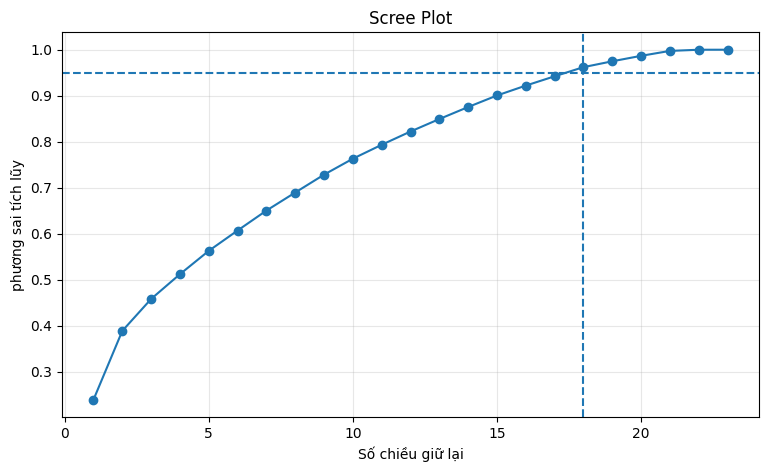

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(range(1, len(cumulative_variance) + 1),cumulative_variance, marker='o')
plt.axhline(0.95, linestyle='--')
plt.axvline(k, linestyle='--')
plt.xlabel('Số chiều giữ lại')
plt.ylabel('phương sai tích lũy')
plt.title('Scree Plot')
plt.grid(True, alpha=0.3)
plt.show()

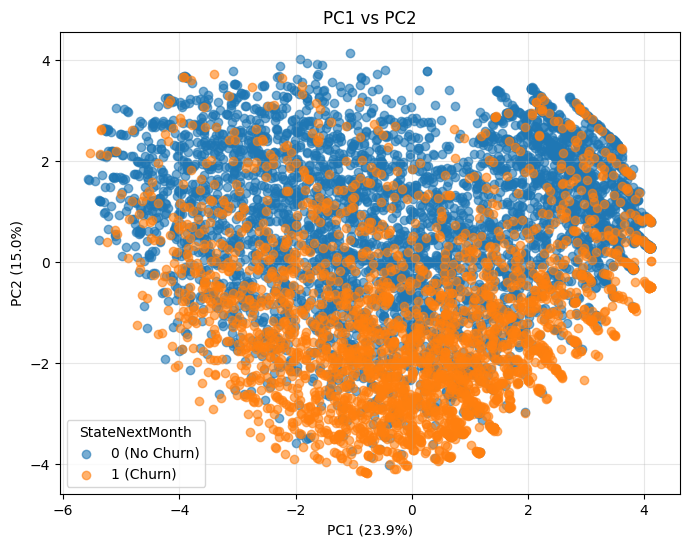

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X1[y == 0, 0], X1[y == 0, 1], alpha=0.6, label='0 (No Churn)')
plt.scatter(X1[y == 1, 0], X1[y == 1, 1], alpha=0.6, label='1 (Churn)')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%})')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%})')
plt.title('PC1 vs PC2')
plt.legend(title='StateNextMonth')
plt.grid(True, alpha=0.3)
plt.show()


**Huấn luyện mô hình**

In [ ]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y, test_size=0.2, random_state = 1, stratify=y
)

X2_train, X2_test, _, _ = train_test_split(
    X2, y, test_size=0.2, random_state = 1, stratify=y
)


In [ ]:
def train_evaluate_svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='rbf', probability=True)
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    metrics = {
        "time": train_time,
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "roc": roc_curve(y_test, y_prob),
        "auc": auc(*roc_curve(y_test, y_prob)[:2]),
        "y_prob": y_prob
    }
    return model, metrics

In [ ]:
svm_pca_model, svm_pca = train_evaluate_svm(
    X1_train, X1_test, y_train, y_test
)

svm_raw_model, svm_raw = train_evaluate_svm(
    X2_train, X2_test, y_train, y_test
)

In [ ]:
import pandas as pd

compare_df = pd.DataFrame({
    "SVM + PCA": {
        "Train time (s)": svm_pca["time"],
        "Accuracy": svm_pca["accuracy"],
        "Recall": svm_pca["recall"],
        "F1-score": svm_pca["f1"],
        "AUC": svm_pca["auc"]
    },
    "SVM (No PCA)": {
        "Train time (s)": svm_raw["time"],
        "Accuracy": svm_raw["accuracy"],
        "Recall": svm_raw["recall"],
        "F1-score": svm_raw["f1"],
        "AUC": svm_raw["auc"]
    }
})

compare_df
#tùy cấu hình máy chạy lại code và tình trạng mạng thì thời gian huấn luyện code sẽ khác nhau trên bản báo cáo

,SVM + PCA,SVM (No PCA)
Train time (s),7.270258,7.798704
Accuracy,0.847410,0.847410
Recall,0.652908,0.652908
F1-score,0.763996,0.763996
AUC,0.835495,0.831484


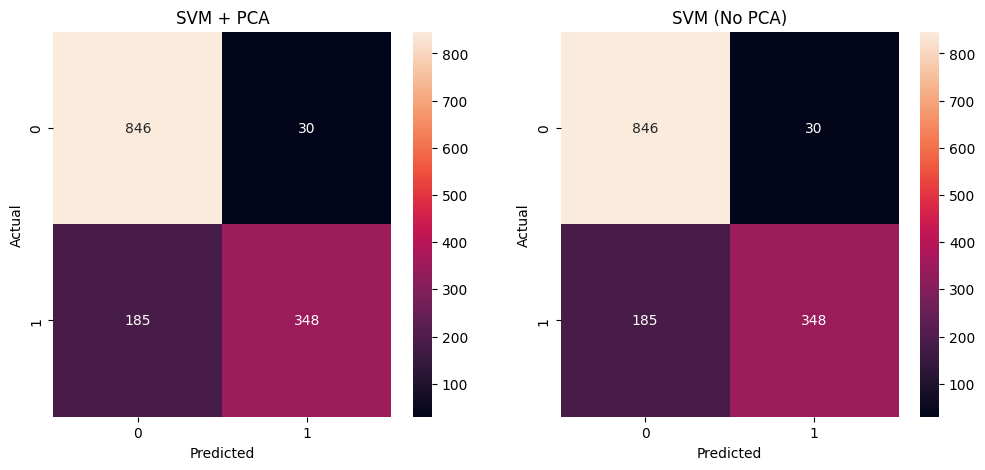

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    svm_pca["confusion_matrix"],
    annot=True, fmt='d', ax=axes[0]
)
axes[0].set_title("SVM + PCA")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    svm_raw["confusion_matrix"],
    annot=True, fmt='d', ax=axes[1]
)
axes[1].set_title("SVM (No PCA)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.show()


In [ ]:
prob_true, prob_pred = calibration_curve(
    y_test,
    svm_pca['y_prob'],
    n_bins=10
)


In [ ]:
brier_score = brier_score_loss(y_test, svm_pca['y_prob'])
print(f"Brier Score (SVM + PCA): {brier_score:.4f}")


Brier Score (SVM + PCA): 0.1264


In [ ]:
brier_score = brier_score_loss(y_test, svm_raw['y_prob'])
print(f"Brier Score (SVM No PCA): {brier_score:.4f}")


Brier Score (SVM No PCA): 0.1266


**Xây dựng xích markov lai**

In [ ]:
churn = df[df['State'] == 1]
churn_nochurn = churn[churn['StateNextMonth'] == 0]
p_return = len(churn_nochurn) / len(churn)
print(p_return)

0.08721241305510968


In [ ]:
np.random.seed(42)

n_customers = 30
months = 6

# chỉ lấy khách đang No Churn
idx_active = np.where(y_test == 0)[0]
sample_idx = np.random.choice(idx_active, size=n_customers, replace=False)
X_sample = X1_test[sample_idx]


In [ ]:
def train_evaluate_svm(X_train, X_test, y_train, y_test):
    model = SVC(kernel='rbf', probability=True)

    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        "model": model,
        "time": train_time,
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob),
        "y_prob": y_prob
    }
    return metrics


In [ ]:
svm_pca = train_evaluate_svm(X1_train, X1_test, y_train, y_test)
svm_model = svm_pca["model"]

p_leave = svm_model.predict_proba(X_sample)[:, 1]
p_matrix = np.full((n_customers, months + 1), np.nan)
p_matrix[:, 0] = p_leave

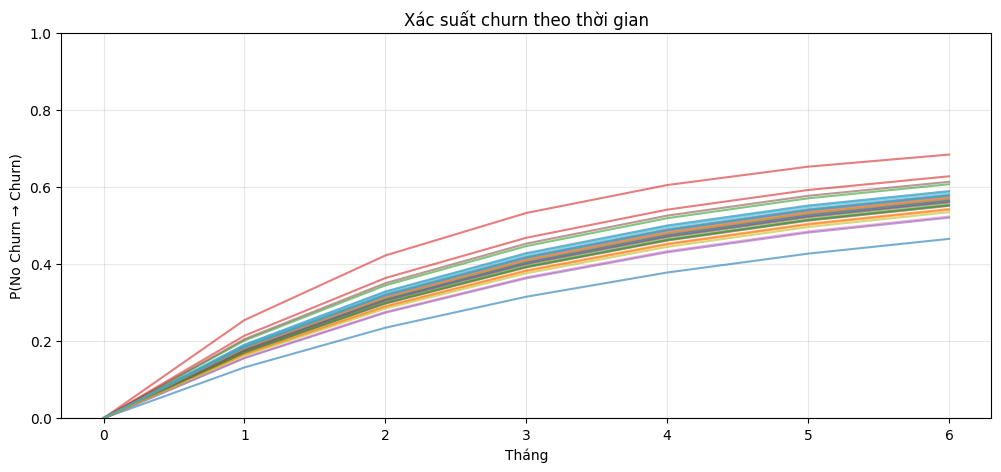

In [ ]:
months = 6
n_customers = 30
def markov_curve(p_leave, p_return, months):
    P = np.array([
        [1 - p_leave, p_leave],
        [p_return, 1 - p_return]
    ])
    pi = np.array([1.0, 0.0])
    churn_prob = [pi[1]]

    for _ in range(months):
        pi = pi @ P
        churn_prob.append(pi[1])

    return np.array(churn_prob)

# Tính cho 30 khách
churn_prob_matrix = np.zeros((n_customers, months + 1))
for i in range(n_customers):
    churn_prob_matrix[i] = markov_curve(
        p_leave[i],
        p_return,
        months
    )
plt.figure(figsize=(12, 5))
for i in range(n_customers):
    plt.plot(churn_prob_matrix[i], alpha=0.6)
plt.xlabel("Tháng")
plt.ylabel("P(No Churn → Churn)")
plt.title("Xác suất churn theo thời gian")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()


**Mô phỏng monte carlo**

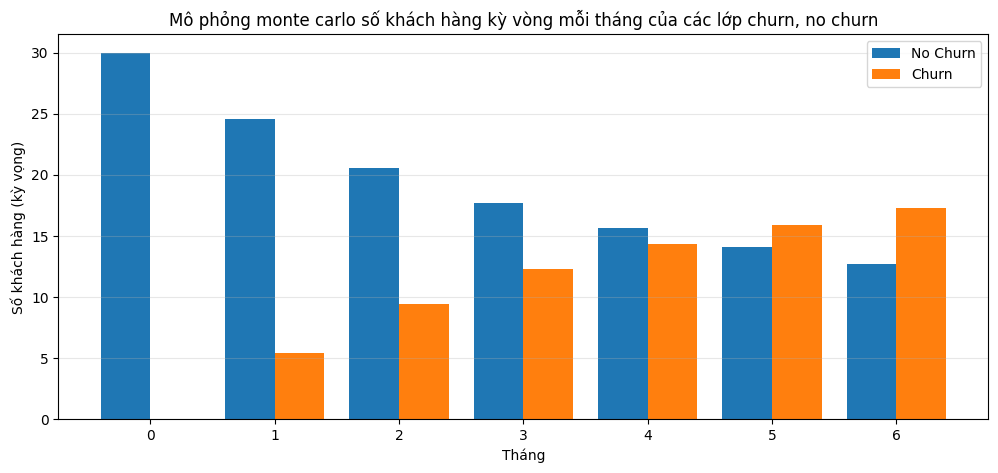

In [ ]:
np.random.seed(42)
months = 6
n_customers = 30
n_sim = 1000
def update_pi(pi, p_leave, p_return):
    P = np.array([
        [1 - p_leave, p_leave],
        [p_return, 1 - p_return]
    ])
    return pi @ P
no_churn_sum = np.zeros(months + 1)
churn_sum = np.zeros(months + 1)
for sim in range(n_sim):
    states = np.zeros((months + 1, n_customers), dtype=int)
    pi = np.zeros((n_customers, 2))
    pi[:, 0] = 1.0
    for t in range(1, months + 1):
        for i in range(n_customers):
            # update xích Markov
            pi[i] = update_pi(pi[i], p_leave[i], p_return)
            # Monte Carlo sampling
            states[t, i] = np.random.choice([0, 1], p=pi[i])
    no_churn_sum += np.sum(states == 0, axis=1)
    churn_sum += np.sum(states == 1, axis=1)
# Trung bình Monte Carlo
no_churn_avg = no_churn_sum / n_sim
churn_avg = churn_sum / n_sim
x = np.arange(months + 1)
w = 0.4
plt.figure(figsize=(12, 5))
plt.bar(x - w/2, no_churn_avg, w, label="No Churn")
plt.bar(x + w/2, churn_avg, w, label="Churn")
plt.xlabel("Tháng")
plt.ylabel("Số khách hàng (kỳ vọng)")
plt.title("Mô phỏng monte carlo số khách hàng kỳ vòng mỗi tháng của các lớp churn, no churn")
plt.xticks(x)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.savefig('mtcarlo')
plt.show()
